In [33]:
import numpy as np
import ray
import matplotlib.pyplot as plt
import time
from utils import *
from procedures import *
plt.rcParams["font.sans-serif"] = "DejaVu Sans"
plt.rcParams["mathtext.default"]  = "it"
plt.rcParams["mathtext.fontset"]  = "dejavusans"

In [34]:
# rewrite the procedure to let it return the budget allocation

def EFGPlus(generator, nsd, n0, ng, G, seed=0, expe_id=-1, **args):

    k = generator.syscount()
    ids = np.arange(k)
    
    np.random.seed(seed)

    counts = np.zeros(k)
    sample_means =  np.zeros(k)
    
    # initial stage seeding 
    for _id in ids:
        sample_means[_id] = np.mean(generator.get(_id, nsd))
    sorted_ids = np.argsort(-sample_means)
    # sampling budget allocation according to seeding rank
    group_sizes = [2**r for r in np.arange(G)]
    segments = group_sizes / np.sum(group_sizes) * k
    segments = np.int32(np.floor(segments))
    segments[-1] = k - np.sum(segments[:-1])
    allocations = n0*(2**G-1)/G/2**np.arange(G)
    allocations = np.floor(allocations)
    _regime = []
    for i in range(G):
        _regime.append(np.ones(segments[i])*allocations[i])
    sample_allocations = np.int32(np.concatenate(_regime))
    print(np.sum(sample_allocations))
    for i, _id in enumerate(sorted_ids):
        sample_means[_id] = np.mean(generator.get(_id, sample_allocations[i]))
        counts[_id] = sample_allocations[i]
    
    N = (n0+ng)*k
    used = np.sum(sample_allocations)
    
    explore_counts = counts.copy()
    greedy_counts = np.zeros(k)
    
    while used < N:
        selected = np.argmax(sample_means)
        sample = generator.get(selected)
        sample_means[selected] = counts[selected] * sample_means[selected] + sample
        counts[selected] += 1
        greedy_counts[selected] += 1
        sample_means[selected]  = sample_means[selected] / counts[selected]
        used += 1
        
    estimated_bestid = np.nanargmax(sample_means)
    
    if expe_id >= 0:
        return expe_id, estimated_bestid, explore_counts, greedy_counts
    else:
        return estimated_bestid, explore_counts, greedy_counts
    


@ray.remote
def remote_EFGPlus(generator, nsd, n0, ng, G, seed=0, expe_id=-1, **args):

    k = generator.syscount()
    ids = np.arange(k)
    
    np.random.seed(seed)

    counts = np.zeros(k)
    sample_means =  np.zeros(k)
    
    # initial stage seeding 
    for _id in ids:
        sample_means[_id] = np.mean(generator.get(_id, nsd))
    sorted_ids = np.argsort(-sample_means)
    # sampling budget allocation according to seeding rank
    group_sizes = [2**r for r in np.arange(G)]
    segments = group_sizes / np.sum(group_sizes) * k
    segments = np.int32(np.floor(segments))
    segments[-1] = k - np.sum(segments[:-1])
    allocations = n0*(2**G-1)/G/2**np.arange(G)
    allocations = np.floor(allocations)
    _regime = []
    for i in range(G):
        _regime.append(np.ones(segments[i])*allocations[i])
    sample_allocations = np.int32(np.concatenate(_regime))
    for i, _id in enumerate(sorted_ids):
        sample_means[_id] = np.mean(generator.get(_id, sample_allocations[i]))
        counts[_id] = sample_allocations[i]
    
    N = (n0+ng)*k
    used = np.sum(sample_allocations)
    
    explore_counts = counts.copy()
    greedy_counts = np.zeros(k)
    
    while used < N:
        selected = np.argmax(sample_means)
        sample = generator.get(selected)
        sample_means[selected] = counts[selected] * sample_means[selected] + sample
        counts[selected] += 1
        greedy_counts[selected] += 1
        sample_means[selected]  = sample_means[selected] / counts[selected]
        used += 1
        
    estimated_bestid = np.nanargmax(sample_means)
    
    if expe_id >= 0:
        return expe_id, estimated_bestid, explore_counts, greedy_counts
    else:
        return estimated_bestid, explore_counts, greedy_counts

In [35]:
# define problem configurations used in EC.3.5

class EMCVGenerator(object):
    def __init__(self, n_alternatives, gamma, lamda, var, best_index=0):
        self.n_alternatives = n_alternatives
        self.gamma = gamma
        self.means = -(np.arange(n_alternatives)-1)/n_alternatives*lamda
        self.means[best_index] = gamma
        self.best_mean = gamma
        self.variances = np.ones(self.n_alternatives)*var
        self.stds = np.sqrt(self.variances)
        
    def get(self, index, n=1):
        return np.random.normal(self.means[index], self.stds[index], n)
        
    def syscount(self):
        return self.n_alternatives
    
class EMCVFuncGenerator(object):
    def __init__(self, n_alternatives, gamma, func, var, best_index=0):
        self.n_alternatives = n_alternatives
        self.gamma = gamma
        self.means = -(np.arange(n_alternatives)-1)/n_alternatives*func(n_alternatives)
        self.means[best_index] = gamma
        self.best_mean = gamma
        self.variances = np.ones(self.n_alternatives)*var
        self.stds = np.sqrt(self.variances)
        
    def get(self, index, n=1):
        return np.random.normal(self.means[index], self.stds[index], n)
        
    def syscount(self):
        return self.n_alternatives

def func2(n):
    return 0.1*n

In [36]:
num_cpus=96
ray.shutdown()
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

RayContext(dashboard_url='', python_version='3.8.0', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:50552', 'raylet_socket_name': 'tcp://127.0.0.1:52759', 'webui_url': '', 'session_dir': 'C:\\Users\\Admin\\AppData\\Local\\Temp\\ray\\session_2023-12-06_20-58-46_316092_58544', 'metrics_export_port': 65191, 'gcs_address': '127.0.0.1:62711', 'address': '127.0.0.1:62711', 'node_id': '333513ebfb3309b15714f8e62b2b5b988433d956107ab935dc8083ed'})

In [37]:
def evaluate_allocation(generators, return_results):
    size = len(return_results)
    explore_allocations = []
    greedy_allocations = []
    for i in range(size):
        counts = return_results[i][2]
        explore_allocations.append(counts)
        counts = return_results[i][3]
        greedy_allocations.append(counts)
    return np.array(explore_allocations), np.array(greedy_allocations)

In [38]:
# rewrite the experiment function to analyze the budget allocation


def parallel_experiments(rng,  generators, policy=None, remote_policy=None, 
                         delta=0.01, test_time=False, args={}):
    _start = time.time()
    results = []
    n_replications = len(generators)
    k = generators[0].syscount()
    print("--------New experiments with  k={}----------------------".format(k))
    for expe_id in range(n_replications):
        _seed = rng.integers(1, 10e8)
        if test_time:
            if expe_id == 0:
                start = time.time()
                policy(generators[expe_id],  **args)
                end = time.time()
                print("Single replication takes: {}s".format(end-start))
                print("Estimated serial total time: {}s".format((end-start)* n_replications))
        else:
            pass
        results.append(remote_policy.remote(generators[expe_id], seed=_seed, expe_id = expe_id, **args))
    print("Start to simulate... at {}".format(time.ctime()))
    results = ray.get(results)
    PCS, PGS = evaluate_PCS(generators, results), evaluate_PGS(generators, results, delta=delta)
    explore_allocations, greedy_allocations = evaluate_allocation(generators, results)
    print("PCS:{}, PGS:{}".format(PCS, PGS))
    _end = time.time()
    print("Total time used: {}s, simulation ends at {}".format(_end-_start, time.ctime()))
    return PCS, PGS, explore_allocations, greedy_allocations

In [39]:
n_replications = 1000
 
min_power = 16
max_power = 16
base = 2

gamma = 0.1
var = 1

n0 = 16
ng = 4
nsd = 2

In [40]:
results = []

seed = 2023112202
np.random.seed(seed)
rng = np.random.default_rng(seed)

        
for func in [func2]:
    for power in np.arange(min_power, max_power+1):
        print("This problem has {} alternatives".format(base**power))
        k = base**power
        G = power
        generators =   [EMCVFuncGenerator(k, gamma, func, var) for i in range(n_replications)]
        PCS, PGS, explore_allocations, allocations = parallel_experiments(rng, generators, policy=EFGPlus, 
                                                     remote_policy=remote_EFGPlus, args={"nsd":nsd, 
                                                                                     "n0":n0, 
                                                                                     "ng":ng,
                                                                                    "G":G})
    results.append(np.mean(explore_allocations, axis=0))

This problem has 65536 alternatives
--------New experiments with  k=65536----------------------
Start to simulate... at Wed Dec  6 20:59:38 2023
PCS:1.0, PGS:1.0
Total time used: 237.8243248462677s, simulation ends at Wed Dec  6 21:03:30 2023


In [41]:
means = EMCVFuncGenerator(k, gamma, func, var).means

In [42]:
# budget allocation of the EFGPlus procedure
results[0]

array([2.9981720e+04, 2.6795032e+04, 2.5054232e+04, ..., 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00])

In [44]:
# results drawn from the above experiments for producing the Figure EC9

# PCS results come from The notebook Figure_EC9_PCS.ipynb

PCS_results = [[0.654,
  0.706,
  0.736,
  0.781,
  0.796,
  0.865,
  0.903,
  0.916,
  0.931,
  0.954,
  0.964,
  0.979,
  0.984,
  0.995],
 [0.521,
  0.585,
  0.553,
  0.632,
  0.661,
  0.678,
  0.661,
  0.657,
  0.668,
  0.663,
  0.658,
  0.676,
  0.671,
  0.678]]

results = [results[0], PCS_results]

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


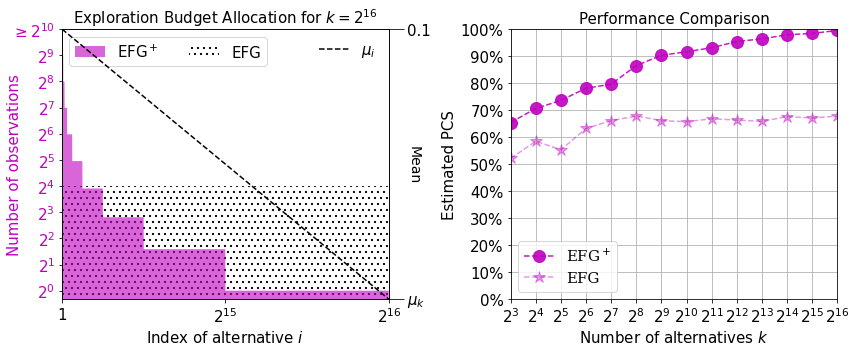

In [97]:
fontsize = 15
powers = np.arange(min_power, max_power+1)

colors = ["blue", "royalblue"]
colors = ["m", "m"]
# colors = ["c", "c"]
markers = ["o","*", "s", "d", "p",  "D", "p"]
line_styles = ["--","--", "-.", ":", "-."]


fig = plt.figure(figsize= (12, 5))

def thresholding(arr, thres):
    return (arr < thres) * arr + (arr >= thres) * thres


fig_plots = [(1,2,1), (1,2, 2)]

titles = ["Exploration Budget Allocation for $k=2^{16}$", "Performance Comparison"]
powers = np.arange(min_power, max_power+1)


for i, fig_plot in enumerate(fig_plots):
    
    ax = fig.add_subplot(*fig_plots[i])
    
    result = results[i]

    if i == 0:
        result = thresholding(result, 2**10)
        plt.fill_between(np.arange(1, k+1), result, facecolor=colors[0], hatch='', interpolate=True,alpha=0.6, label="EFG$^+$")
        plt.fill_between(np.arange(1, k+1), np.ones(k)*n0, facecolor=colors[1], hatch='..', interpolate=True, 
                         zorder=-1, 
                         alpha=0.00, label="EFG")
        
        plt.yscale("log", base=2)
        
        max_y = 2**10
        plt.ylim(0.8, max_y)
        yticks = [2**i for i in np.arange(0, 11)]
        yticklabels = ["2^{"+str(power)+"}" for power in np.arange(0, 11)]
        #yticklabels = [str(2 ** (power)) for power in yticks]
        yticklabels = ["$"+power_label+"$" for power_label in yticklabels]
        yticklabels[-1] = "$\geq$" + yticklabels[-1]
        plt.yticks(yticks, yticklabels,color=colors[i], fontsize=fontsize)
        print(yticks)

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'k'
        ax2.set_ylabel("Mean", color=color, rotation=-90, size=fontsize-1,labelpad=-10)  # we already handled the x-label with ax1
        ax2.plot(np.arange(1, k+1), means,  "--", color=color, label="$\mu_i$")
        ax2.tick_params(axis='y', labelcolor=color, size=fontsize)

        ax2.set_ylim(np.min(means), 0.1)
        ax2.set_yticks([np.min(means), 0.1],["$\mu_k$", "0.1"], size=fontsize)

        plt.xlim(1, k)
        xticks = [1, k/2, k]
        xticklabels = ["2^{"+str(power)+"}" for power in [1, 15, power]]
        xticklabels[0] = "1"
        xticklabels[-1] = "2^{16}"
        xticklabels = ["$"+power_label+"$" for power_label in xticklabels]
        ax.set_xticks(xticks, xticklabels, fontsize=fontsize)

        ax.legend(prop={"size":fontsize}, loc='upper left', ncol=2, markerscale=1.0)
        ax2.legend(prop={"size":fontsize}, loc='upper right',  markerscale=1.0,frameon=False)
        ax.set_xlabel("Index of alternative $i$", size=fontsize)
        ax.set_ylabel("Number of observations", size=fontsize, labelpad=-10, color=colors[i])
        
    if i==1:
        labels = ["EFG$^+$", "EFG"]
        alphas = [0.9, 0.4]
        powers = np.arange(3, 16+1)
        for i, result in enumerate(results[i]):
            plt.plot(powers, result, line_styles[i], marker=markers[i], markersize=12,  color=colors[0], label=labels[i],
                    alpha = alphas[i])

        min_power, max_power = 3, 16
        plt.xlim(min_power, max_power)
        xticks = np.arange(min_power, max_power+1)
        xticklabels = ["2^{"+str(power)+"}" for power in xticks]
        #xticklabels = [str(2 ** (power)) for power in xticks]
        xticklabels = ["$"+power_label+"$" for power_label in xticklabels]
        plt.xticks(powers, xticklabels,fontsize=fontsize)
        
        
        plt.ylim(0.0,1.0)
        yticks = np.arange(0.0,1+0.1, 0.1)
        yticklabels = ["%.0f"%(tick*100)+"%" for tick in yticks]
        plt.yticks(yticks, yticklabels, fontsize=fontsize)

        plt.legend(prop={'family': 'serif',"size":fontsize})
        plt.xlabel("Number of alternatives $k$", size=fontsize)
        plt.ylabel("Estimated PCS", size=fontsize)
        plt.grid(0.1)
        
    plt.title(titles[i], fontsize=fontsize)

fig.tight_layout()
plt.savefig("Figure_EC9.pdf", bbox_inches ="tight")
plt.show()